# Emotion Detector

This notebook will train a neural network to detect six types of emotions (*Angry*, *Disgust*., *Fear*, *Happy*, *Sad*, *Surprise*) plus a neutral expression in human faces. The approach is similar to the [Kaggle challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/overview) proposed seven years ago. The network and data loaders were build in [PyTorch](https://pytorch.org/).

## Prepare the data
We use the [FER2013](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) dataset to train our model. First off, teh dataset has to be downloaded. For a cleaner routine, we provide a PyTorch Dataset implementation for the dataset. Thus, the first step is to create such a Dataset object and a DataLoader. To have a quick look at the data and ensure that everything went well, we display the first entries from the training set with their labels.

In [1]:
from data import FER2013, CombiDataset
import network as n
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torchvision.transforms as t

fer_root = 'fer2013_data'
ck_root = 'ckplus_data'
fe_root = 'facial_expressions'

# Create and inspect data
#labeled_dataset = CombiDataset(fer_root, ck_root, fe_root, 
   #transform=t.Compose(
    #[t.ToPILImage(),
     #t.RandomChoice([
         #t.RandomAffine(degrees=(-30,30), translate=(0.2,0.2), scale=(0.8, 1.2), fillcolor=125),
         #t.RandomCrop((48,48), pad_if_needed=True, padding=(4,4), padding_mode='symmetric')]),
     #t.ToTensor()]),
                               #reduce_emotions=True)
     
#labeled_dataset = CombiDataset(fer_root, ck_root, fe_root, reduce_emotions=True)
labeled_dataset = FER2013(fer_root, reduce_emotions=True)
num_test = int(len(labeled_dataset)*0.2)
train_dataset, validation_dataset = random_split(labeled_dataset, [len(labeled_dataset)-num_test, num_test])
test_dataset = FER2013(fer_root, train=False)
print("No of training samples:", len(train_dataset))
#print("No of augmented training samples:", len(labeled_dataset_t))
print("No of test samples:", len(test_dataset))
print("No of validation samples:", len(validation_dataset))
LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
LABELS = ['Angry/Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Make data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)


%load_ext autoreload
%autoreload 2

No of training samples: 22968
No of test samples: 7178
No of validation samples: 5741


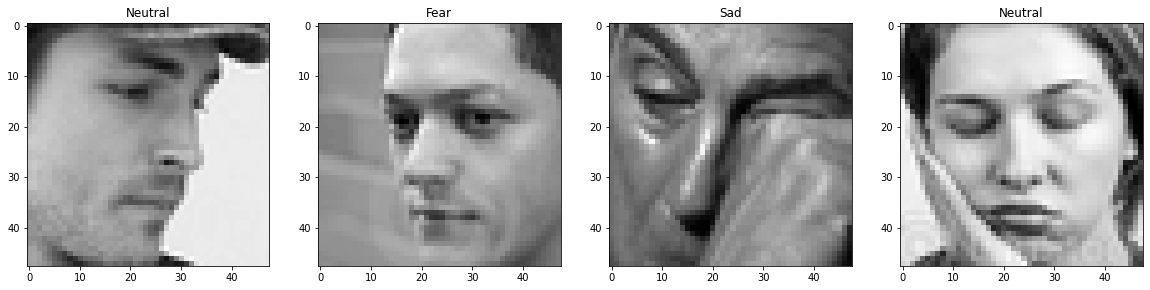

In [2]:
# Display the data
fig, ax = plt.subplots(1,4, figsize=(20, 5))
for i in range(4):
    img, emotion = train_dataset.__getitem__(i)
    ax[i].imshow(img.reshape(48, 48), cmap='gray')
    ax[i].set_title(LABELS[emotion])
plt.show()

## Train the network

  0%|          | 0/180 [00:00<?, ?it/s]

Use cuda: False
Train with normal training samples:
Epoch 1


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 1.7756266163455114
Epoch 2


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 1.6570914755264918
Epoch 3


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 1.576293170452118
Epoch 4


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 1.5064233538177279
Epoch 5


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 1.444294162326389
Epoch 6


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 1.3879872334224206
Epoch 7


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 1.332035082200217
Epoch 8


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 1.2747573932011922
Epoch 9


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 1.2142155887903991
Epoch 10


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 1.1534990870124764
Epoch 11


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 1.0929847215010662
Epoch 12


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 1.0357220727743375
Epoch 13


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.9814175999635815
Epoch 14


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.9320207590385089
Epoch 15


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.886417617055553
Epoch 16


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.8451659793448117
Epoch 17


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.8062343845910885
Epoch 18


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.7712845073529968
Epoch 19


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.7389013576098005
Epoch 20


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.7092942988158514
Epoch 21


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.6822332525202048
Epoch 22


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.6571635595692152
Epoch 23


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.6337828626280317
Epoch 24


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.6120631697346215
Epoch 25


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.5920284721499516
Epoch 26


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.5736696033254982
Epoch 27


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.556327967199884
Epoch 28


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.5399487170381545
Epoch 29


  0%|          | 0/180 [00:00<?, ?it/s]

Average Loss: 0.5246936270790495
Epoch 30


100%|██████████| 180/180 [07:12<00:00,  2.41s/it]

Average Loss: 0.5102910380870863


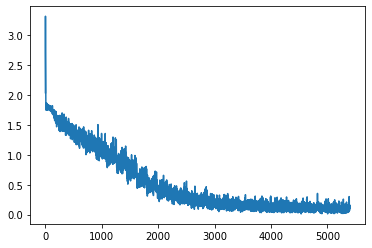

In [4]:
import torch
from tqdm import tqdm
import numpy as np

use_cuda = torch.cuda.is_available()
print("Use cuda:", use_cuda)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")

model = n.EmotionClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=10e-6)
loss_function = torch.nn.NLLLoss()
loss_history = []
    
print("Train with normal training samples:")
for epoch in range(30):
    print("Epoch", epoch+1)
    for imgs, emos in tqdm(train_loader):
        data = imgs.to(device)
        optimizer.zero_grad()
        fwd = model(data)
        loss = loss_function(fwd, emos.to(device).long())
        loss.backward()
        loss_history.append(loss.item())
        optimizer.step()
    print("Average Loss:", np.mean(loss_history))

plt.plot(np.arange(len(loss_history)), loss_history)
plt.show()

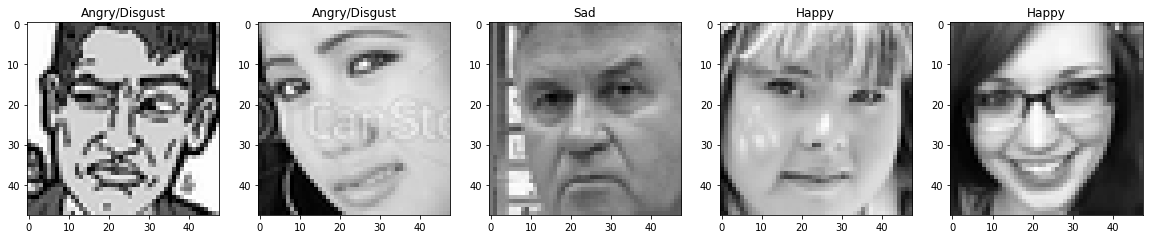

In [5]:
fig, ax = plt.subplots(1,5, figsize=(20, 4))
for imgs in test_loader:
    data = imgs.to(device)
    fwd = model(data)
    emotion = torch.argmax(fwd, dim=1)
    for i in range(imgs.shape[0]):
        img = data.cpu().numpy()[i]
        ax[i].imshow(img.reshape(48, 48), cmap='gray')
        ax[i].set_title(LABELS[emotion[i]])
    break
plt.show()

In [9]:
model.eval()
confusion_matrix = np.zeros((6,6))
corrects = 0
for imgs, emos in tqdm(val_loader):
    data = imgs.to(device)
    fwd = model(data)
    pred = torch.argmax(fwd, dim=1).cpu().numpy()
    emos = emos.cpu().numpy()
    corrects += np.sum(np.where(pred == emos, 1, 0))
    for i in range(7):
        confusion_matrix[pred[i]][emos[i]] += 1
accuracy = corrects * (100/len(validation_dataset))
print("Accuracy:", accuracy)

100%|██████████| 45/45 [00:32<00:00,  1.38it/s]

Accuracy: 58.0735063577774


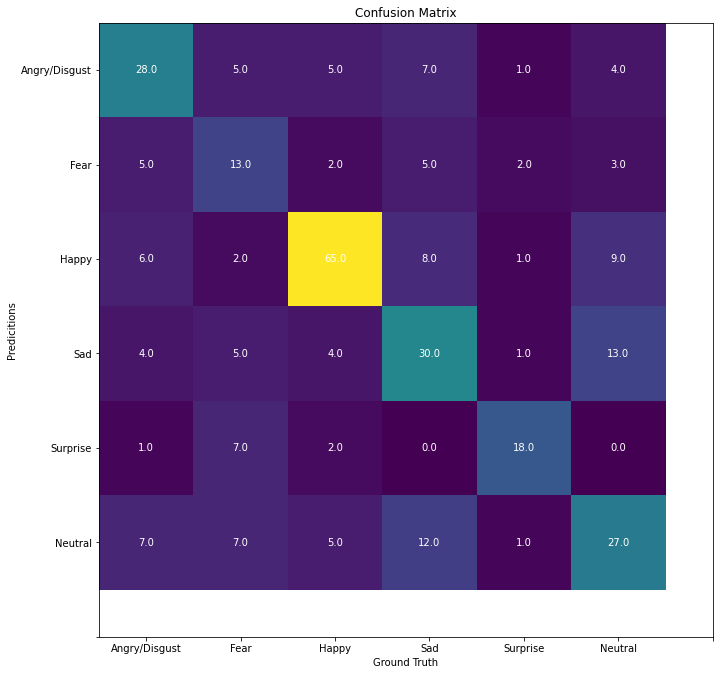

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
img = ax.imshow(confusion_matrix)
for i in range(6):
    for j in range(6):
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="w")

ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(7))
ax.set_xticklabels(LABELS)
ax.set_yticklabels(LABELS)
ax.set_xlabel("Ground Truth")
ax.set_ylabel("Predicitions")
ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()

In [13]:
torch.save(model.state_dict(), '/home/fenja/Repos/EmotionalRide/EmotionDetection/model-light.pt')